## Predicting and Forecasting Volatility

In the first part of this notebook we will look at some simple techniques to estimate volatility. This is followed by a few well known classic volatility models which include ARCH, GARCH, GJR-GARCH and EGARCH. Regression and ML-based models are then explored. The aim is to begin with the simplest models for forecasting volatility, and then gradually add complexity. To get the best out of our model, we can tune hyperparameters, add or remove variables, alter the macro structure of the estimator, impose constraints or force symmetries.

Some questions to think about and discuss as you make your way through the notebook. This can also help form the short analysis at the end of the day. <br>
1. Why must I always be careful of leakage? Does my model have exhibit leakage? Have I checked the returns and the variance calculations? Have I shuffled any of my datasets?
2. Why must I log transform the returns? Why is this suggested and how does it align with the forecast models?
3. What are some of the variables that can potentially add insight and which ones are detrimental to model performance? 
4. At which point should I stop adding complexity, i.e., at what point is the improvement marginal or less than the standard errors of my estimates? Is the additional run time worth the improvement?
5. What are the implications of having 1 model to forecast volatility using ARCH and say 5 models using regression or ML? What are the advantages and disadvantages of either? Would you conclude that one is clear-cut better than the other?
6. Which horizon is easier to forecast and why? 
7. Do the various asset classes exhibit similar model performance? Do they use similar model structures?
8. What assumptions have I made? Under what conditions is my model valid? When do these no longer hold?


***

### **A. Getting Started**

#### **Enviromenment Setup and Package Imports**

In the quantathon directory you will see a requirements file with a list of packages needed for the notebook. Install this in the environment you'll be using for the quantathon.

Using virtualenv: <br>
`` $ pip install virtualenv `` <br>
`` $ virtualenv quant_env`` <br>
`` $ .\quant_env\Scripts\activate`` <br>
Navigate to wherever you've saved the requirements file and then <br>
`` $ pip install -r requirements.txt`` <br>

While still in your environment, install PPYM accordingly. You should now be able to load the following packages and modules.

In [3]:
import numpy as np 
import pandas as pd 
import math
import datetime
import matplotlib.pyplot as plt
import importlib
plt.style.use('seaborn-v0_8')


#In-house modules
from ppym import pimdb as pdb
from ppym.pimmdk import labels 

# GAM
import gam_cv

# utils
import utils_vol
from utils_vol import *

# Arch
from arch import arch_model

# warnings
import warnings
warnings.filterwarnings("ignore")

# Yahoo Finance
import yfinance as yf

# Optuna
import optuna 
from optuna.visualization.matplotlib import plot_slice

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.ensemble import RandomForestRegressor

# Relaoding packages. 
# For example if you make changes to utils_vol, you can load the changes as follows.
importlib.reload(utils_vol)
from utils_vol import *


#### **S&P 500**

We will demonstrate the concepts using close prices of the S&P 500, which is available in our database. A more refined dataset can be sourced via the Yahoo finance package, giving not only the close prices, but also open, low and high prices. We extract data using either source. 

You will be tasked with modelling different assets. So have a look at what the Yahoo Finance packages has to offer that will be relevant to your asset class. 

In [2]:
start_date = datetime.date(2010, 1, 1)
end_date = datetime.date(2022, 1, 1)

# Get some price data. Please add you own credentials.
db_engine = pdb.create_engine_pim(driver='mysql+pymysql', host='pim-cpt-mysql-prod.prescient.local', port=3307, database='prime_eav',
    username='xx',
    password='xx',
    connect_args=None
)

df = pdb.get_series(['SPX Index'], ['PX_LAST'], list_source_codes=['BB'], start_date=start_date, end_date=end_date,  db_engine=db_engine
)

# Create a series of close prices
S = pd.Series(df.value.values, index =df.datestamp.values)


# Log transform the price series.
S = np.log(S)

# Create the label object for the price data. 
label = labels.ClassificationLabels(S)


In [3]:
# Open, close, low and high data of the S&P 500 from Yahood Finance.
stocks = '^GSPC'
sp500 = np.log(yf.download(stocks, start=start_date, end = end_date, interval='1d')) # Log transform of the price data.

[*********************100%%**********************]  1 of 1 completed


#### **Daily Returns**

<Axes: ylabel='Daily returns'>

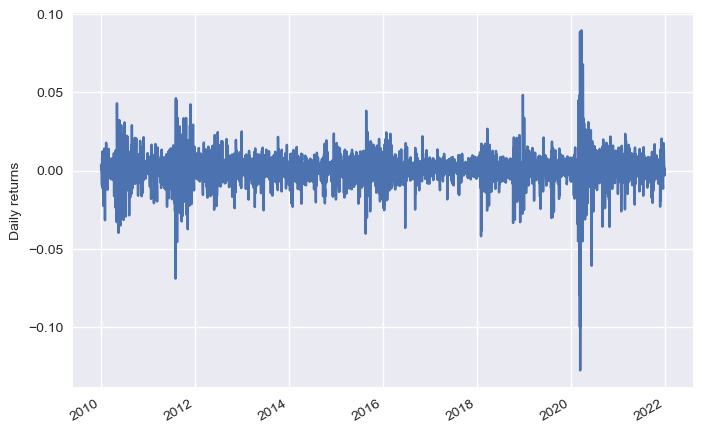

In [8]:
ret = 100*label.abs_return_forward(1) # The scale is to enable the ARCH package to accurately estimate model parameters.
                                      # This is a forward-looking return. Let's keep this as daily. 
                                      # What will happen if we used backward returns?
(ret/100).plot(ylabel='Daily returns')

#### **Realised Variance (Actual)**

<Axes: ylabel='Realised volatility: 5-day rolling'>

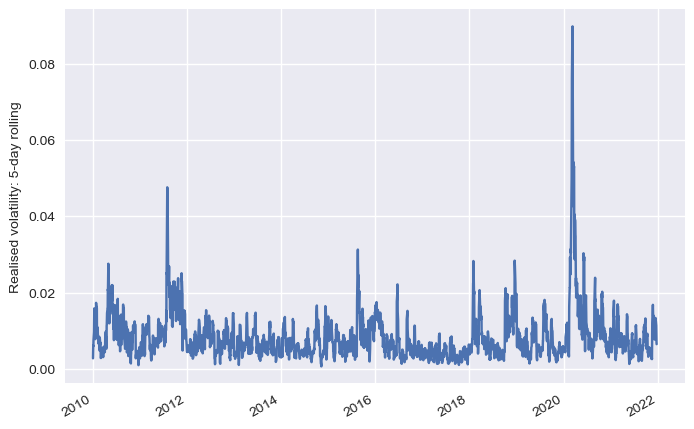

In [9]:
h = 5 # Change this value throughtout the modelling process to asess which horizon is easiest and/or hardest to predict.
      # Note that this is a forward-looking horizon.

realised_var = var_act(ret, h)  # Again, these are forward looking varainces, i.e., actual realised variances.
                               
np.sqrt(realised_var/10000).plot(ylabel='Realised volatility: {}-day rolling'.format(h)) # Plot the volatility - square-root of the variance.
                                                                                         # Divide by 10000, because we scaled the returns by 100. 

*** 

### **B. Variance Estimates: Equally and Exponentially Weighted Moving Average Methods**

Since we do not have access to future returns, we can estimate the variance at each time based on a series of $k$ past returns, or a weighted series of past returns with characteristic factor $\alpha$. 

<Axes: ylabel='Estimated volatility (Equally Weighted): 53-day rolling'>

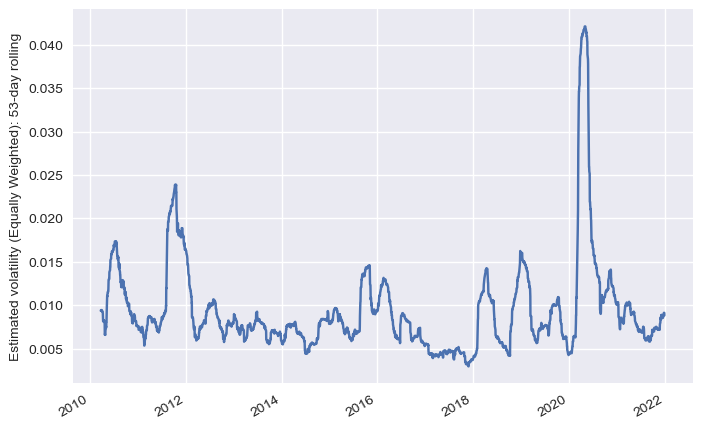

In [6]:
k=53 # Number of past datapoints. Note that this does not include the current day. 
alpha=0.019 # Smoothing factor using a selection of historic data points, not including the current day.

var_est_eqwma = var_est_eq_wma(ret, k)/10000 
var_est_exwma = var_est_expon_wma(ret, alpha)/10000
var_est_exwmaz0 = var_est_expon_wma_z0(ret, alpha)/10000

np.sqrt(var_est_eqwma).plot(ylabel='Estimated volatility (Equally Weighted): {}-day rolling'.format(k))
#plt.figure(); np.sqrt(var_est_exwma).plot(ylabel=r'Estimated volatility (Exponentially Weighted): $\alpha$={}'.format(alpha))
#plt.figure(); np.sqrt(var_est_exwmaz0).plot(ylabel=r'Estimated volatility (Exponentially Weighted): $\alpha$={}'.format(alpha))

#### **Testing our Estimators: Variance Proportion Explained**

The variance proprtion (VPE) explained is similar to the $R^2$ metric we've used before, but uses the mean of errors and not the sum as in the $R^2$ metric. Compare equations for notable differences. We will be using VPE to test our models going forward. 

In [10]:
# As an example:
print('The VPE is: {}'.format(VPE(realised_var/10000,var_est_exwmaz0)))

The VPE is: 0.03323754784464439


#### **Maximum Log-Likelihood**
The maximum log-likelihood criteria can be used as an objective for selecting the best parameters for the above volatility models based on a distribution assumed by the data. Here we assume the volatility to have a log-normal distribution and the noise process to be normally distributed.

In [11]:
# As as example:
print('The log-likelohood is: ', log_likelihood(var_est_eq_wma, ret=ret, k=53))

The log-likelohood is:  2194.1592775881973


[I 2023-10-05 11:17:52,005] A new study created in memory with name: volatility
[I 2023-10-05 11:17:52,011] Trial 0 finished with value: 2242.905664097905 and parameters: {'alpha': 0.08732254441918644}. Best is trial 0 with value: 2242.905664097905.
[I 2023-10-05 11:17:52,014] Trial 1 finished with value: 2189.191179563065 and parameters: {'alpha': 0.1070416649006877}. Best is trial 0 with value: 2242.905664097905.
[I 2023-10-05 11:17:52,019] Trial 2 finished with value: 2032.2180680120057 and parameters: {'alpha': 0.1648739759017264}. Best is trial 0 with value: 2242.905664097905.
[I 2023-10-05 11:17:52,023] Trial 3 finished with value: 2393.229700574941 and parameters: {'alpha': 0.02098186352966927}. Best is trial 3 with value: 2393.229700574941.
[I 2023-10-05 11:17:52,027] Trial 4 finished with value: 2097.22825191456 and parameters: {'alpha': 0.140995890373978}. Best is trial 3 with value: 2393.229700574941.
[I 2023-10-05 11:17:52,030] Trial 5 finished with value: 1966.437306765521

--------------------------------------------------------------------------------------
Best trial:  72
Best likelihood: 2393.46
Best hyperparameters: {'alpha': 0.019973317265325245}
--------------------------------------------------------------------------------------


<Axes: title={'center': 'Slice Plot'}, xlabel='alpha', ylabel='Objective Value'>

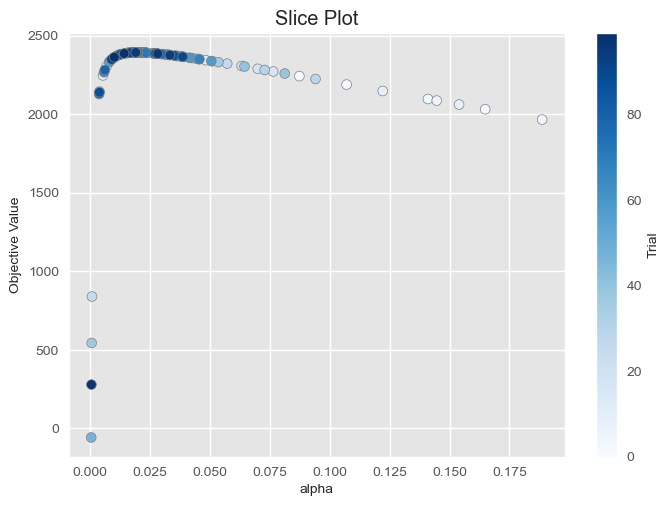

In [12]:
# Now lets use an objective based on the log-likehood to find the optimal parameters for our model.

func = var_est_expon_wma_z0 # Change this to find optimal parameters for the various etimators.
                            # var_est_eq_wma,  var_est_expon_wma_z0, var_est_expon_wma

study = optuna.create_study(direction='maximize',study_name='volatility', sampler=optuna.samplers.TPESampler())
study.optimize(lambda trial: objective(trial, func, ret=ret), n_trials=100)

print('--------------------------------------------------------------------------------------')
print('Best trial: ', study.best_trial.number)
print('Best likelihood: {:.2f}'.format(study.best_trial.value))
print('Best hyperparameters: {}'.format(study.best_trial.params))
print('--------------------------------------------------------------------------------------')
plot_slice(study)

***

### **C. Variance Estimates: GARCH Models**


We will use the ARCH package to fit ARCH or GARCH models on the training dataset. The parameters dictate the type of model that will be built. Here are some parameter options and model guidelines. 

1. ``mean``: The mean process - 'zero', 'constant', 'ARX', 'HARX', 'LS'
2. ``vol``: The volatility process - 'GARCH', 'EGARCH', 'HARCH', 'FIGARCH'
3. ``p``- Lag order of the lagged returns.
4. ``q`` - Lag order of lagged variance or equivalent.
5. ``o``- Lag order of the asymmetric innovation.
    
- **ARCH**: Autoregressive Conditonal Heteroskedasticity <br>
 A function of p. vol='GARCH'.

2. **GARCH**: Generalised ARCH <br>
A function of p and q. vol='GARCH'.

3. **GJR-GARCH**: Glosten-Jagannathan-Runkle GARCH  (asymmetric)<br>
A function of p, q and o. vol='GARCH'.

4. **E-GARCH**: Exponential GARCH (asymmetric)<br>
A function of p and q. vol='EGARCH'

#### **Train-Test Splits**
Going foward we will split our dataset into train and test sets. The VPE will be calculated on the test set only.

In [13]:
# The minimum number of training points to start off with.
n_train = 2000

# Returns 
ret_train = ret.iloc[:n_train]

# Realised variance
realised_var_test = realised_var.iloc[n_train:]


#### **Fitting an ARCH Model**


In [14]:
# Estimate the model parameters (e.g omega, alpha, etc) based on the training set only.
# I supsect that the ARCH package fits on all the data it sees, however, we only want to fit on the train set.
# Not sure if there is a better way to do this via the API. 
# But this is my quick solution. 

arch_train_res = arch_model(ret_train, mean='zero', vol='EGARCH', p=1, q=1).fit(disp='off')  # Fit on the train set.
# print(arch_train_res.summary())

arch = arch_model(ret, mean='zero', vol='EGARCH', p=1, q=1)
arch_res =  arch.fix(arch_train_res.params.values)  # Fix the parameters of the model based on the fit using only the train data.
print(arch_res.summary())

                           Zero Mean - EGARCH Model Results                          
Dep. Variable:                          None   R-squared:                          --
Mean Model:                        Zero Mean   Adj. R-squared:                     --
Vol Model:                            EGARCH   Log-Likelihood:               -3812.34
Distribution:                         Normal   AIC:                           7630.68
Method:            User-specified Parameters   BIC:                           7648.72
                                               No. Observations:                 3022
Date:                       Thu, Oct 05 2023                                         
Time:                               11:19:09                                         
   Volatility Model   
                  coef
----------------------
omega      -3.9261e-03
alpha[1]        0.2666
beta[1]         0.9541

Results generated with user-specified parameters.
Std. errors not available when the mo

#### **Next-Day Forecasting**

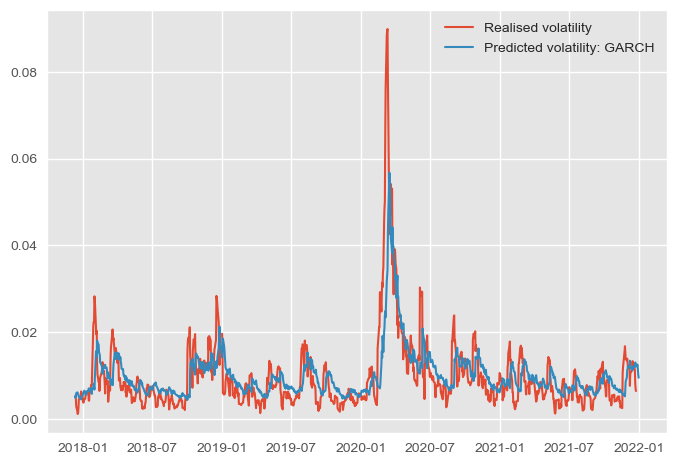

In [15]:
# Forecast one day ahead on the test data as observations become available. 
forecasts = arch_res.forecast(start=ret_train.index[-1], horizon=1, reindex=False) 

# Plot the one-day-ahead forecasts.
plt.figure()
plt.plot(np.sqrt(realised_var_test/10000), label='Realised volatility', linewidth=1.5)
plt.plot(np.sqrt(forecasts.variance.shift(periods=1)/10000), label='Predicted volatility: GARCH', linewidth=1.5)
plt.legend(); plt.show()

#### **Testing the Model Performance and Selecting the Best Number of Lags**

In [17]:
# This can be expanded to select the best number of lagged asymmetric innovations. So add another loop for parameter o.
bic_values = []
p_values = np.arange(1,10) 
bic_best = 1e6
for p in range(1,10):
    for q in range(1,10):
        arch_train_res = arch_model(ret_train, mean='zero', vol='GARCH', p=p, q=q).fit(disp='off')  # Fit on the train set.
        if arch_train_res.bic < bic_best: 
            bic_best=arch_train_res.bic
            p_best, q_best = p, q
print('The best number of lagged squared returns is:', p_best)
print('The best number of lagged variances is:', q_best)

The best number of lagged squared returns is: 1
The best number of lagged variances is: 1


#### Refitting the Model Using Optimal Parameters

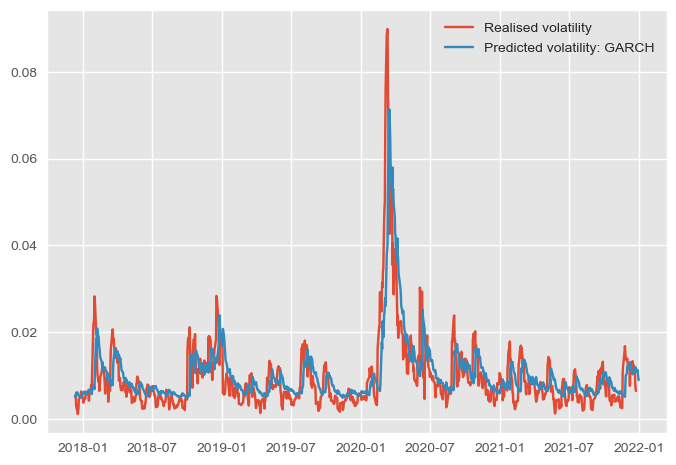

In [18]:
# Refit the model.
arch_train_res = arch_model(ret_train, mean='zero', vol='GARCH', p=p_best, q=q_best).fit(disp='off')  # Fit on the train set.

# Fix the parameters of the model based on the fit using the train data.
arch = arch_model(ret, mean='zero', vol='GARCH', p=p_best, q=q_best)
arch_res =  arch.fix(arch_train_res.params.values)  

# Forecast one day ahead on the test data as observations become available. 
forecasts = arch_res.forecast(start=ret_train.index[-1], horizon=1, reindex=False) 

# Plot the one-day-ahead forecasts.
plt.figure()
plt.plot(np.sqrt(realised_var_test/10000), label='Realised volatility')
plt.plot(np.sqrt(forecasts.variance.shift(periods=1)/10000), label='Predicted volatility: GARCH')
plt.legend(); plt.show()

#### **Long Horizon Daily Forecasts**

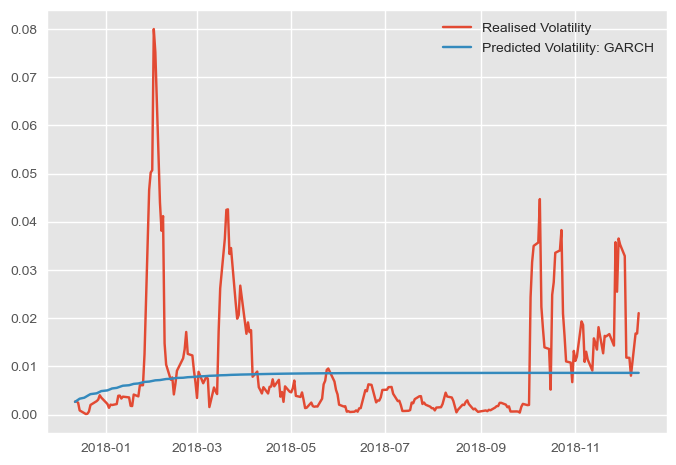

In [15]:
# Forcast a larger horizon using the last available observation. 

arch_train_res = arch_model(ret_train, mean='ARX', vol='GARCH', p=p_best, q=q_best).fit(disp='off') 
forecasts = arch_train_res.forecast(horizon=252, reindex=False) 

forecasts_df = pd.DataFrame(data=forecasts.variance.values.T, index=realised_var_test[0:252].index, columns=['forecasts'])

# Plot the one-day-ahead forecasts.
plt.figure()
plt.plot(realised_var_test[0:252]/100, label='Realised Volatility')
plt.plot(forecasts_df/100, label='Predicted Volatility: GARCH')
plt.legend()
plt.show()


#### **Exogenous Variables**

Garman Klass estimates of the daily variance can be used as additional variables into the ARCH model. 

In [20]:
# Here we use the data provided to us from Yahoo finance
# What other variables can be added to the GARCH model?

ret2_gk = garman_klass(sp500.Open, sp500.Close, sp500.Low, sp500.High)
ret2_gk=ret2_gk.dropna().iloc[:-1]
idx = ret2_gk.index.intersection(ret.index)
ret=ret.loc[idx]
ret2_gk=ret2_gk.loc[idx]

#### **Putting it All Together**
Let's wrap all of the above into a single function that can forecast the various horizons. Here you can explore further by feeding in different parameters, adding exogenous variables, forecasting a different asset class, adding more observations, etc.  

In [25]:
n_train = 2000
n_test = 1000
f_update = 10
forecasts, actual = arch_h(ret=ret, realised_var=realised_var, n_train=n_train, n_test=n_test, 
                           x=None, f_update=f_update, method='simulation', mean='zero', vol='EGARCH', p=p_best, q=q_best, o=1)
vpe = np.round(VPE(actual, forecasts),4)
print('VPE for horizons [5, 21, 63, 126, 192, 252]: {}'.format(vpe))

                           Zero Mean - EGARCH Model Results                          
Dep. Variable:                          None   R-squared:                          --
Mean Model:                        Zero Mean   Adj. R-squared:                     --
Vol Model:                            EGARCH   Log-Likelihood:               -3389.19
Distribution:                         Normal   AIC:                           6786.38
Method:            User-specified Parameters   BIC:                           6810.06
                                               No. Observations:                 2747
Date:                       Thu, Oct 05 2023                                         
Time:                               11:33:38                                         
   Volatility Model  
                 coef
---------------------
omega      8.1956e-06
alpha[1]       0.2439
gamma[1]      -0.1752
beta[1]        0.9436

Results generated with user-specified parameters.
Std. errors not avail

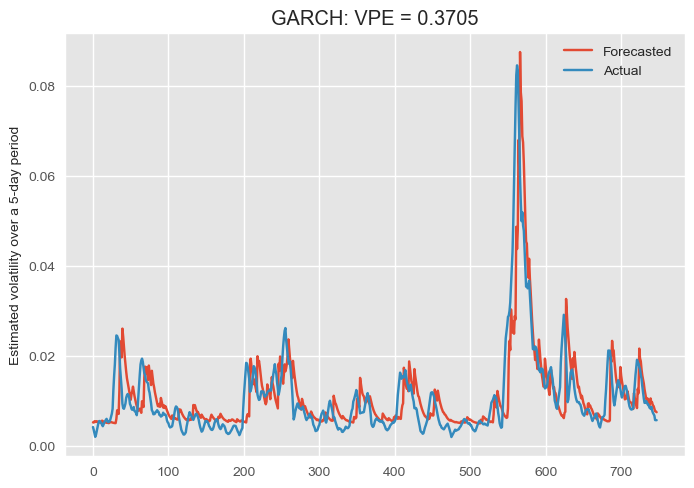

In [18]:
h = [5, 21, 63, 126, 192, 252]
i=0 # Select the forecast horizon to plot.

plt.plot(np.sqrt(np.array(forecasts[:,i])/10000), label='Forecasted')
plt.plot(np.sqrt(np.array(actual[:,i])/10000), label='Actual')
plt.ylabel('Estimated volatility over a {}-day period'.format(h[i]))
plt.title('GARCH: VPE = {}'.format(vpe[i]))
plt.legend()
plt.show()

***
### **D. Regression and ML-based Models** 

The task of of forecasting volatility can be converted into a regression-based framework and is thus suitable for ML-based estimators as well. The difference between this approach and the GARCH methods we saw earlier is that in regression-based methods we only feed in historic data, which in this case can include returns, volatilities, implied volatilities, or any other factors that are relevant to the asset class. So they do not take as inputs the expected values of the previous model outputs.

#### **Features and Target**
Remember that you can only insert into your model the data that will be available at the current day. So if you've calculated a return or a realised volatilty using future data, that cannot be added to the model. In this simple example I will use only the past returns and a few backward-looking variances as inputs to the model. You can be more comprehensive in your variable selection. 

The target variable is the actual realised variance. Regression and ML-based estimators will require a single model per forecast horizon. 

#### **Purging**
Since our returns have fixed horizons, it it easy to keep track of which target labels have overlap. As an example, consider a horizon of 126. The last observation in the training set would overlap with 125 observations in the test set. Adding a safety margin, we should therefore remove the first 126+13 observations from the test set as shown in the example below.

#### **Variable Standardization**
It is in certain cases recommended to standardize or normalize the inputs to a model. Does this make a difference in your model? 


In [132]:
# Features. 
# Add more or less look-back periods.
var1 = var_est_eq_wma(ret, 1)/10000 # var1 is just the squared returns of the previous day.
var5 = var_est_eq_wma(ret, 5)/10000
var21 = var_est_eq_wma(ret, 21)/10000
var63 = var_est_eq_wma(ret, 63)/10000

features = pd.concat({'var1': var1, 'var5': var5, 'var21': var21, 'var63': var63}, axis=1)
 

# Target variable - realised variance. We will have one model per forecast horizon. So h will change.
h = 5
target = var_act(ret, h)/10000


# Since var63 does not have values for the first 63 days and the target set does not have data for the last 4 days (assuming a horizon of 5, h=5), we can drop these indices across our datsets such that 
features = features.iloc[63:-h+1].dropna()
target = target.iloc[63:-h+1].dropna()

idx = features.index.intersection(target.index)
features = features.loc[idx]
target = target.loc[idx]


# It is possible to percentile rank the data. Instead you can just standardize the data.
features_pr = features.rank(pct=True)
target_pr = target.rank(pct=True)


# Create a default train-test split.
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=2000, shuffle=False)


# Standardize the data. Remember to descale at the end.
scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train.values.reshape(-1, 1))
X_train_scaled, X_test_scaled = scaler_x.transform(X_train), scaler_x.transform(X_test)
y_train_scaled, y_test_scaled = scaler_y.transform(y_train.values.reshape(-1, 1)), scaler_y.transform(y_test.values.reshape(-1, 1))

features_scaled = scaler_x.transform(features)
target_scaled = scaler_y.transform(target.values.reshape(-1, 1))
features_scaled = pd.DataFrame(features_scaled, index=features.index, columns=features.columns)
target_scaled = pd.Series(target_scaled.flatten(), index=target.index)


# Test set purging and embargoeing.
X_test = X_test.iloc[126+int(np.ceil(0.1*126)):]
y_test = y_test.iloc[126+int(np.ceil(0.1*126)):]


#### **Elastic Net** 

We can wrap the above into a general function to predict forward-looking variances for multiple horizons. Here you can specify your own choice of estimator and its arguments. Some estimators have embedded parameter searches such as the Elastic Net below. In this case you will input a parameter grid. Notice that we have used a simple cross-validation method for simplicity. Should we have used purged-combinatorial k-fold? 

In [144]:
n_train = 2000 # Minimum number of train samples
n_test = None # Number of test samples.
f_update = 50   # How often should we re-train the model?
estimator = ElasticNetCV
your_args = {'alphas': np.logspace(-12, -0.8, 200), 
             'l1_ratio': [.1, .2, .3, .4, .5, .7, .9, .95, .99, 1],
             'positive': False,
             'cv': 2} 

predict_h, actual_h, model_h = est_h(features, ret, estimator, n_train, n_test, f_update , scale=True,  **your_args)

ElasticNet intercept:  0.07222184363878131
L1 ratio:  0.1


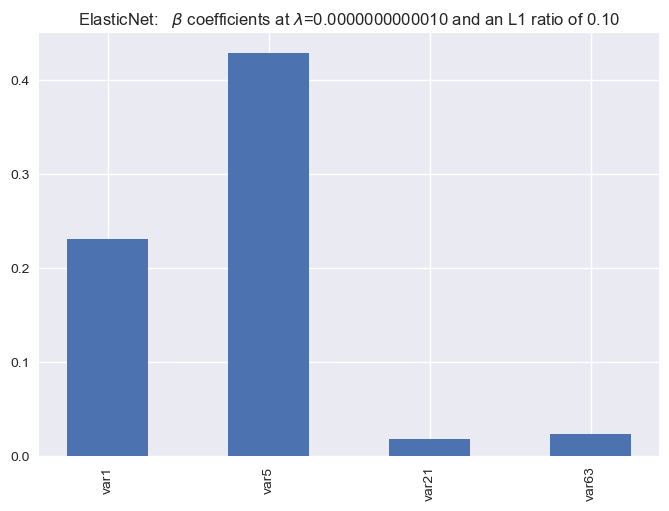

In [145]:
# Select a horizon from  [5, 21, 63, 126]
h = [5,21,63,126]
i = 0

# Model coeficients
print('ElasticNet intercept: ', model_h[i].intercept_)
print('L1 ratio: ', model_h[i].l1_ratio_)

# Plot the variable weights.
# Assess which variables are more important that others.
# Would there be a significant improval in performance if we added variables and/or removed those already in the model?

plt.figure()
ax = plt.axes()
plt.bar(range(4), model_h[i].coef_, width=0.5)
plt.title(r"ElasticNet:   $\beta$ coefficients at $\lambda$={:.13f} and an L1 ratio of {:.2f} ".format(model_h[i].alpha_, model_h[i].l1_ratio_))
bars_label = list(features.columns)
ax.set_xticks(range(len(features.columns)), bars_label, rotation='vertical')
plt.show()

df_coef = pd.DataFrame(index=features.columns, data=model_h[i].coef_, columns=['beta coefficient'])

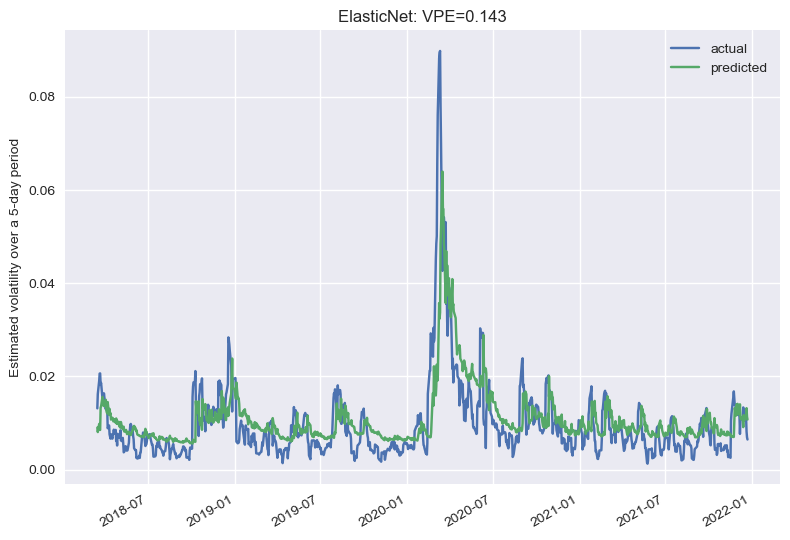

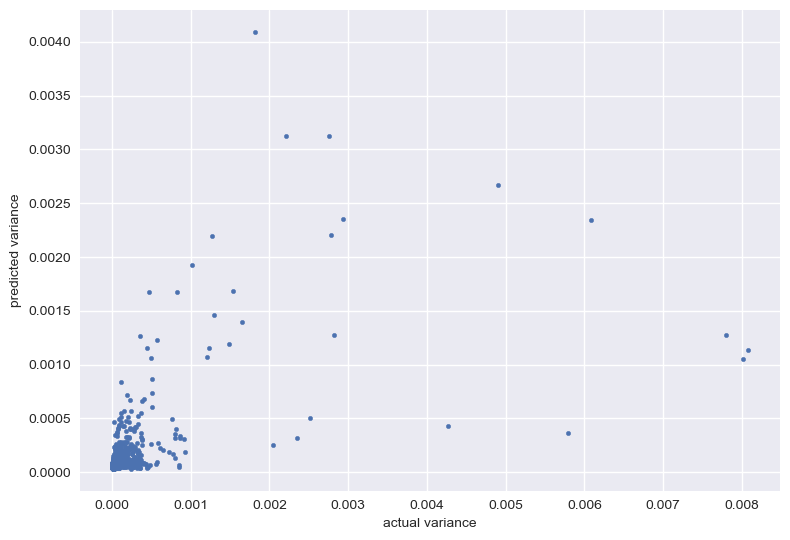

In [146]:
# Test the model 
vpe = np.round([VPE(actual_h[i].values, predict_h[i].values) for i in range(len(predict_h))], 4)

# Plot the results
np.sqrt(actual_h[i]).plot(label='actual') 
np.sqrt(predict_h[i]).plot(label='predicted')
plt.ylabel('Estimated volatility over a {}-day period'.format(h[i]))
plt.title( 'ElasticNet: VPE={}'.format(vpe[i]))
plt.legend()
plt.tight_layout()

plt.figure()
plt.scatter(actual_h[i], predict_h[i], s=10)
plt.xlabel('actual variance')
plt.ylabel('predicted variance')
plt.tight_layout()

#### **SVR - Support Vector Regression**

In [169]:
# Support vector regresssion with a linear kernel. Would a more complex kernel be better?
estimator_svr = SVR(kernel='linear')

# Parameter search. Is the search space sufficient?
# This should be done for each model (each horizon). Note that here the same set of parameters is used for all models.
parameters = {'gamma':np.arange(0,10)/100, 'C':np.arange(0,30)/10, 'epsilon':np.arange(0,10)/100} # 'kernel': ['linear', 'rbf'] 

gs = GridSearchCV(estimator_svr, parameters, cv=5)
gs.fit(X_train,y_train)
print(gs.best_params_)

{'C': 2.9, 'epsilon': 0.0, 'gamma': 0.0}


In [170]:
n_train = 2000 # Minimum number of train samples
n_test = None # Number of test samples.
f_update = 50   # How often should we re-train the model?
estimator = SVR
predict_h, actual_h, model_h = est_h(features, ret, estimator, n_train, n_test, f_update , scale=True, kernel='linear', **gs.best_params_)    

VPE: [ 0.2544  0.1264  0.0487 -0.0337]


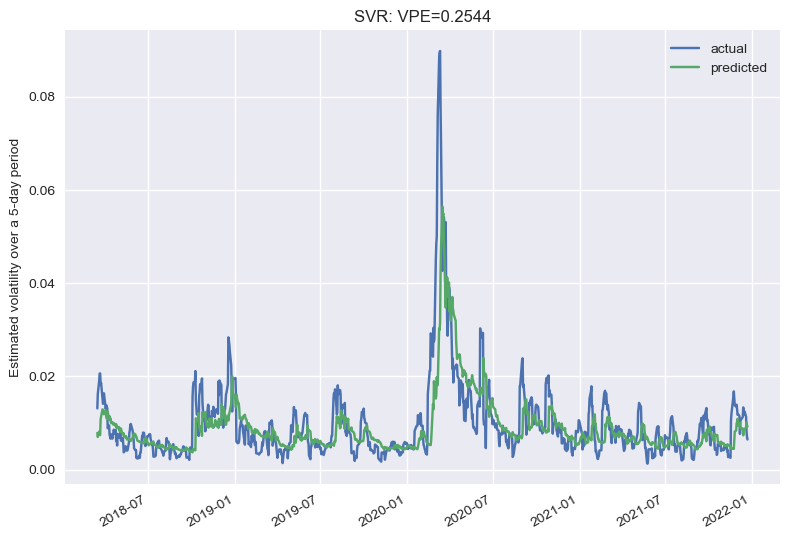

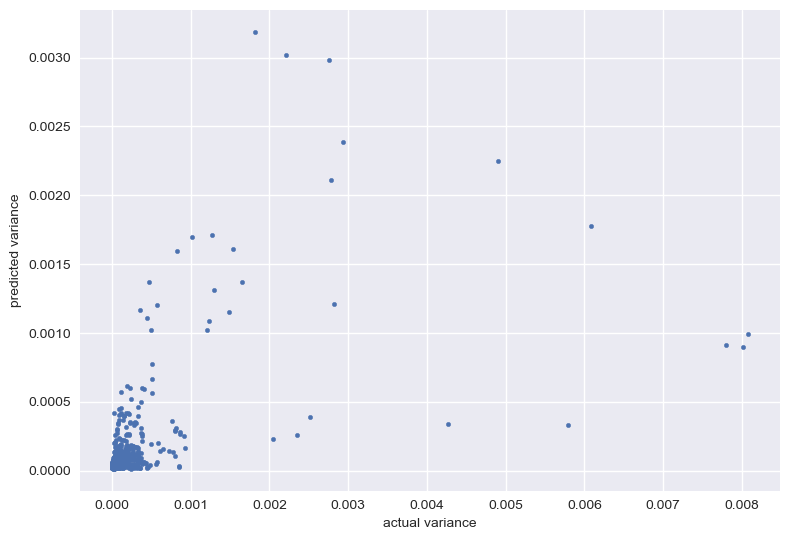

In [171]:
# Test the model 
vpe = np.round([VPE(actual_h[i].values, predict_h[i].values) for i in range(len(predict_h))], 4)
print('VPE: {}'.format(vpe))

# Plot the results
h= [5,21,63,126]

np.sqrt(actual_h[i]).plot(label='actual') 
np.sqrt(predict_h[i]).plot(label='predicted')
plt.ylabel('Estimated volatility over a {}-day period'.format(h[i]))
plt.title( 'SVR: VPE={}'.format(vpe[i]))
plt.legend()
plt.tight_layout()

plt.figure()
plt.scatter(actual_h[i], predict_h[i], s=10)
plt.xlabel('actual variance')
plt.ylabel('predicted variance')
plt.tight_layout()

### **Regression Trees** 

In [150]:
# Parameter search. This should be done for each model (each horizon). Note that here the same set of parameters is used for all models.
estimator_rf = RandomForestRegressor()
parameters = {'n_estimators':[200, 300], 'max_depth':[2, 3, 4, 5], 'max_features':[1.0,'sqrt','log2']} #'criterion':['squared_error','absolute_error'],
gs = GridSearchCV(estimator_rf, parameters, cv=10)
gs.fit(X_train,y_train)
print(gs.best_params_)

{'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 200}


In [151]:
# Define some tree estimators of choice
estimator_rf = RandomForestRegressor

n_train = 2000 # Minimum number of train samples.
n_test = None # Number of test samples.
f_update = 100   # How often should we re-train the model?
estimator = estimator_rf # Choose your estimator.

predict_h, actual_h, model_h = est_h(features, ret, estimator, n_train, n_test, f_update, scale=False, **gs.best_params_)  # max_depth=4, n_estimators=200, max_features='sqrt', criterion='squared_error'

VPE: [ 0.1518  0.0872  0.019  -0.0255]


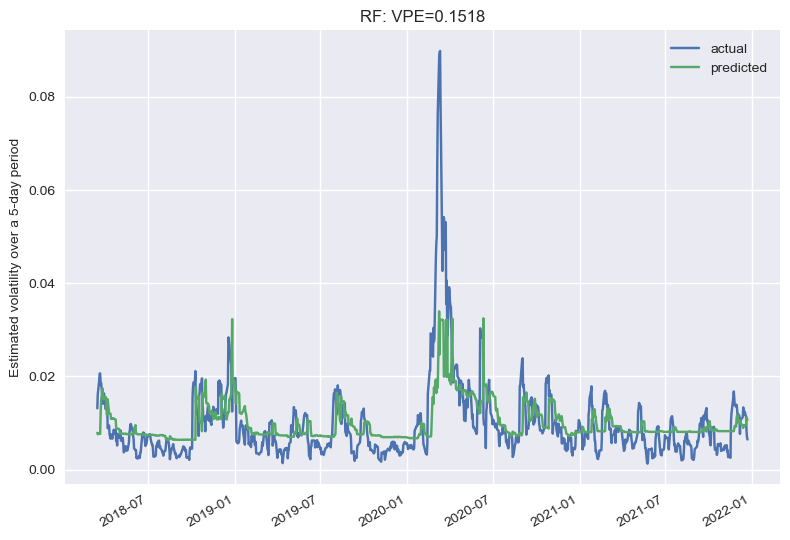

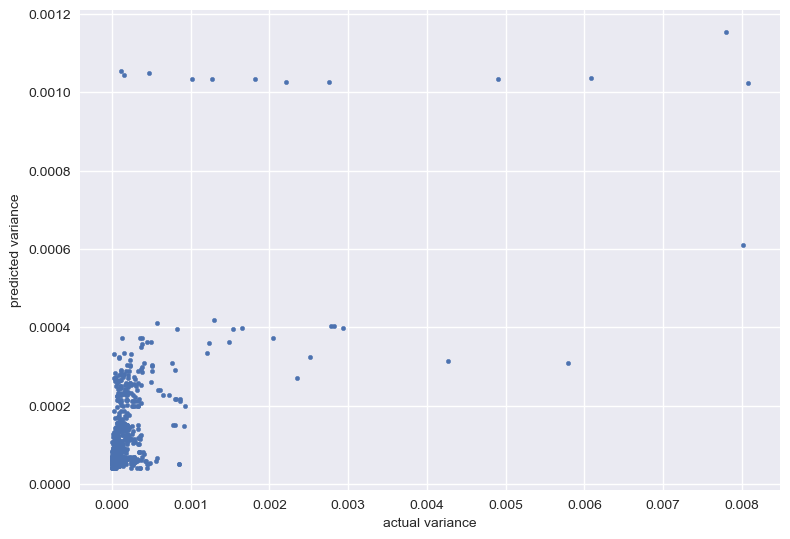

In [152]:
# Test the model 
vpe = np.round([VPE(actual_h[i].values, predict_h[i].values) for i in range(len(predict_h))], 4)
print('VPE: {}'.format(vpe))

# Plot the results
h= [5,21,63,126]
i=0

np.sqrt(actual_h[i]).plot(label='actual') 
np.sqrt(predict_h[i]).plot(label='predicted')
plt.ylabel('Estimated volatility over a {}-day period'.format(h[i]))
plt.title( 'RF: VPE={}'.format(vpe[i]))
plt.legend()
plt.tight_layout()

plt.figure()
plt.scatter(actual_h[i], predict_h[i], s=10)
plt.xlabel('actual variance')
plt.ylabel('predicted variance')
plt.tight_layout()

#### **Other ML and Regression Models**

Use the multiple horizon function to explore other esimators available. Perform a parameter search to obtain a well-tuned model. The crosss-validation method in these searches should ideally inlcude purging.


#### **The GAM**

In [153]:
# Features. 
# Add more or less look-back periods.
var1 = var_est_eq_wma(ret, 1)/10000 # var1 is just the squared returns of the previous day.
var5 = var_est_eq_wma(ret, 5)/10000
var21 = var_est_eq_wma(ret, 21)/10000
var63 = var_est_eq_wma(ret, 63)/10000

features = pd.concat({'var1': var1, 'var5': var5, 'var21': var21, 'var63': var63}, axis=1)
 

# Target variable - realised variance. We will have one model per forecast horizon. So h will change.
h = 5
target = var_act(ret, h)/10000


# Since var63 does not have values for the first 63 days and the target set does not have data for the last 4 days (assuming a horizon of 5, h=5), we can drop these indices across our datsets such that 
features = features.iloc[63:-h+1].dropna()
target = target.iloc[63:-h+1].dropna()

idx = features.index.intersection(target.index)
features = features.loc[idx]
target = target.loc[idx]


# It is possible to percentile rank the data. Instead you can just standardize the data.
features_pr = features.rank(pct=True)
target_pr = target.rank(pct=True)


# Create a default train-test split.
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=2000, shuffle=False)


# Standardize the data. Remember to descale at the end.
scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train.values.reshape(-1, 1))
X_train_scaled, X_test_scaled = scaler_x.transform(X_train), scaler_x.transform(X_test)
y_train_scaled, y_test_scaled = scaler_y.transform(y_train.values.reshape(-1, 1)), scaler_y.transform(y_test.values.reshape(-1, 1))

features_scaled = scaler_x.transform(features)
target_scaled = scaler_y.transform(target.values.reshape(-1, 1))
features_scaled = pd.DataFrame(features_scaled, index=features.index, columns=features.columns)
target_scaled = pd.Series(target_scaled.flatten(), index=target.index)


# Test set purging and embargoeing.
X_test = X_test.iloc[126+int(np.ceil(0.1*126)):]
y_test = y_test.iloc[126+int(np.ceil(0.1*126)):]

# Again we will use a simple cross-validation method.
cv = KFold(n_splits=5, random_state=None, shuffle=False)

# Fit the GAM.
gamcv = gam_cv.GamCV(X_train, y_train, cv, penalties='l2', constraints='monotonic_inc', lam=None, n_splines=None, spline_order=None, sample_weights=None, X_intercept=None, y_intercept=None)
r2, study, gam_best, gam_fit = gamcv.call()

[I 2023-10-05 15:12:44,772] A new study created in memory with name: gam_parameters


--------------------------------------------------------------------------------------
A Linear GAM will be created (with Normal distribution and Identity link)
--------------------------------------------------------------------------------------


[I 2023-10-05 15:12:45,398] Trial 0 finished with value: -0.10004114507533127 and parameters: {'lambda_1': 9.912719484196483e-05, 'lambda_2': 8.433551791541463e-05, 'lambda_3': 9.477419021291348e-05, 'lambda_4': 1.3484162905575338e-05, 'spline_order': 5, 'n_splines': 11}. Best is trial 0 with value: -0.10004114507533127.
[I 2023-10-05 15:12:46,047] Trial 1 finished with value: -0.07162790166558855 and parameters: {'lambda_1': 5.7791707387729566e-05, 'lambda_2': 1.9260606966712858e-05, 'lambda_3': 3.9563430440300394e-05, 'lambda_4': 6.231249181960331e-05, 'spline_order': 2, 'n_splines': 17}. Best is trial 1 with value: -0.07162790166558855.
[I 2023-10-05 15:12:46,403] Trial 2 finished with value: -0.08455129726461288 and parameters: {'lambda_1': 8.584361835123064e-05, 'lambda_2': 8.310578723879792e-06, 'lambda_3': 8.155933453167697e-05, 'lambda_4': 2.1059933351085137e-06, 'spline_order': 1, 'n_splines': 11}. Best is trial 1 with value: -0.07162790166558855.
[I 2023-10-05 15:12:47,113] T

--------------------------------------------------------------------------------------
Tuning is complete
Best trial:  97
Best cross-validated r^2: -0.02
Best hyperparameters: {'lambda_1': 6.726625190009741e-05, 'lambda_2': 3.147202249164977e-05, 'lambda_3': 5.122754510595721e-05, 'lambda_4': 1.4468299137632407e-05, 'spline_order': 1, 'n_splines': 2}
--------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------
Final remarks
A Linear GAM is created
Lambda value/s: [6.726625190009741e-05, 3.147202249164977e-05, 5.122754510595721e-05, 1.4468299137632407e-05].
Spline order: 1.
Number of splines: 2.
Test set r^2: 0.19129868790118498
--------------------------------------------------------------------------------------


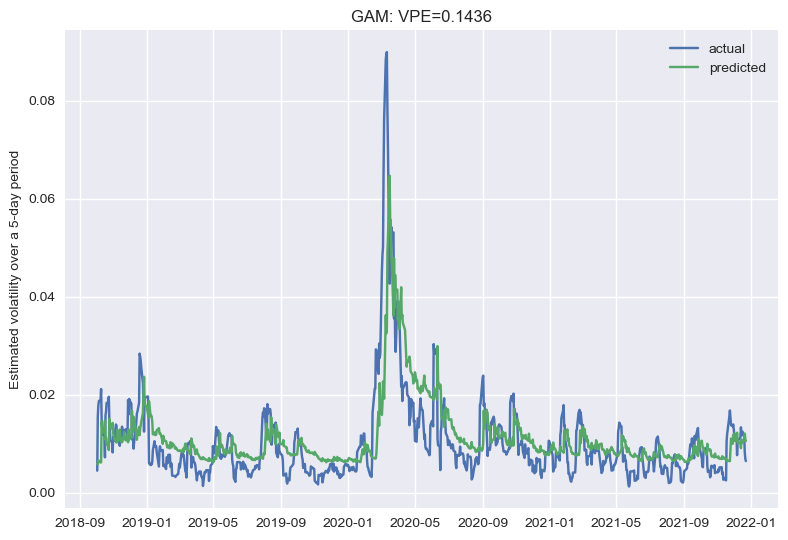

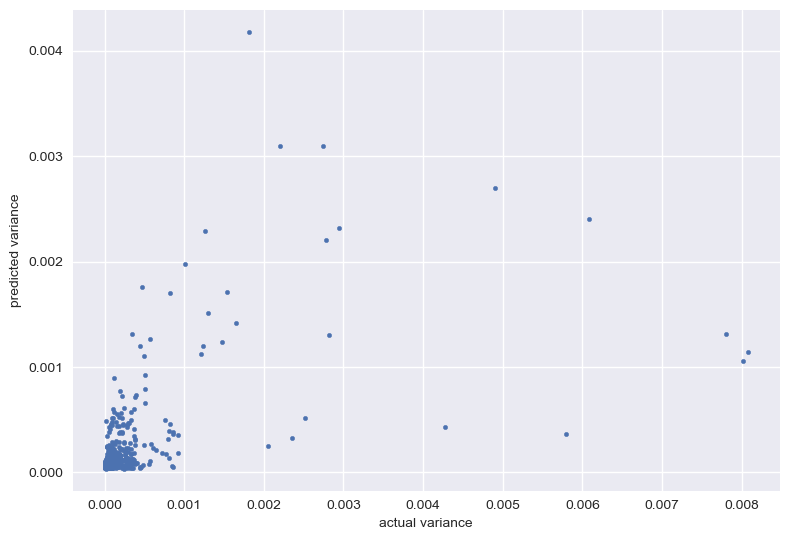

In [154]:
# Model prediction
predict = gam_fit.predict(X_test)

# Model testing.
vpe = round(VPE(y_test.values, predict),4)

# Plot the result. 
plt.figure()
plt.plot(y_test.index, np.sqrt(y_test.values),   label='actual')
plt.plot(y_test.index, np.sqrt(predict),  label='predicted')
plt.ylabel('Estimated volatility over a {}-day period'.format(h))
plt.title( 'GAM: VPE={}'.format(vpe))
plt.legend()
plt.tight_layout()

plt.figure()
plt.scatter(y_test.values, predict, s=10)
plt.xlabel('actual variance')
plt.ylabel('predicted variance')
plt.tight_layout()
